In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from pandas import json_normalize


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set_theme()

import plotly.express as px
import tarfile
import json
import csv
import random
import json

# Load environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv("API_key.env")  # take environment variables from .env.
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from yelpapi import YelpAPI
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from gql.transport.aiohttp import AIOHTTPTransport
import requests

import argparse
from pprint import pprint

#Librairie de Tokenisation
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.tag.util import str2tuple

# Gensim
import gensim
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from joblib import dump, load
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Utilisation de l'API YELP et transformation par Pipeline

La collecte des données via une API est complète si :

    ❒ une requête pour obtenir les données via l’API a été écrite, testée, et renvoie bien des données en retour
    ❒ seuls les champs nécessaires ont été récupérés 
    ❒ au moins un filtre a été appliqué sur un des champs nécessaires pour ne collecter que les avis ayant les valeurs correspondantes sur ces champs 
    ❒ les données collectées via l’API sont stockées dans un fichier utilisable (ex. : fichier CSV, avec en colonnes les différentes informations correspondant aux avis)


### Récupération de données par API

   [Yelp Fusion API](https://www.yelp.com/developers/documentation/v3/get_started)
   
   [Business Search](https://www.yelp.com/developers/documentation/v3/business_search)
   
   [Review](https://www.yelp.com/developers/documentation/v3/business_reviews)
   
   [GraphQL Yelp](https://www.yelp.com/developers/graphql/guides/intro)
   
   [GraphQL](https://graphql.org/)
   
   [Cours OC API Rest](https://openclassrooms.com/fr/courses/6573181-adoptez-les-api-rest-pour-vos-projets-web)
   
Les endpoints API Fusion sont accessibles à l'adresse suivante: https://api.yelp.com/v3

Des exemples de codes d'appel aux API sont accessible ici: https://github.com/Yelp/yelp-fusion#code-samples


In [2]:
# function to add to JSON
def write_json(new_data, filename='data.json'):
    with open(filename,'r+', encoding='utf-8') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, ensure_ascii=False, indent = 4)
    #return(print('json data append OK'))

#Function to plot PIE Chart of n tops values in dataframe
def plot_ntops_pie(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    
    #Définir la taille du graphique
    plt.figure(figsize=(8,8))
    #Définir lae type du graphique, ici PIE CHart avec en Labels l'index du nom des libelle
    #l'autopct sert ici à afficher le % calculé avec 1 décimal derriere la virgule
    plt.pie(podium_tops[colunm_name], labels=podium_tops.index, autopct='%1.1f%%')
    #Afficher la légende en dessous du graphique au centre
    plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.01), fancybox=True, shadow=None, ncol=2)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def plot_ntops_bar(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    #Définir la taille du graphique
    fig, ax = plt.subplots(figsize=(15,10))
    #Définir lae type du graphique, ici BARPLOT avec en Labels l'index du nom des libelle
    ax = sns.barplot(data=podium_tops, x=podium_tops.index, y=colunm_name)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

#Create function that study boxplot
def plot_boxplot(data: pd.DataFrame, x_axis, colunms_selected: list, plot_outliers: bool): 
    for col in colunms_selected:
        sns.set()
        fig, ax = plt.subplots(figsize=(15, 5))
        sns.boxplot(x=x_axis, 
                    y=col, # column is chosen here
                    data=data,
                    #order=["a", "b"],
                    showfliers = plot_outliers,
                    showmeans=True,
                    )  
        sns.despine(offset=10, trim=True) 
        plt.title(f"Column {col} boxplot per {x_axis}")
        plt.show()

In [3]:
# Load environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv("API_key.env")  # take environment variables from .env.
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")

In [4]:
api_key =  YELP_API_KEY
# define our authentication process.
header = {'Authorization': 'bearer {}'.format(api_key), 'Content-Type':"application/json"}

# Build the request framework
transport = RequestsHTTPTransport(url='https://api.yelp.com/v3/graphql', headers=header, use_json=True)

# Create the client
client = Client(transport=transport, fetch_schema_from_transport=True)

Nous construisons un Query qui prend en compte les limitations définies par l'API YELP GraphQL.

Nous souhaitons associer à cette information une photo pour chaque restaurant.


In [14]:
#
filename_paris_json = './API_Extract/data4.json'
filename_paris_csv = './API_Extract/data4.csv'

#initialize the file with an empty list
with open(filename_paris_json, 'w', encoding='utf-8') as f:
    json.dump([], f)
with open(filename_paris_csv, "w", encoding='utf-8') as f:
  # now you have an empty file already
  pass  # or write something to it already


# define a looped query
skipcurrent = 0
limit_API_return = 50
totalAPIcalls = 20
totalAPIindex = (totalAPIcalls * limit_API_return)

while skipcurrent < totalAPIindex:
    # set query
    query = gql('''
    {
    search(location: "paris", limit: '''+str(limit_API_return)+''', offset: '''+str(skipcurrent)+''') {
        business {
            name
            reviews {
                rating
                text
                }
            }
        }
    }
    ''')
    # execute and print this query
    #print('-'*100)
    json_string = client.execute(query)
    #print(json_string)
    skipcurrent = skipcurrent + limit_API_return #updating skip number       
    write_json(json_string, filename_paris_json)
print(f'GraphQL API calls have returned data, stored in JSON file {filename_paris_json}')


GraphQL API calls have returned data, stored in JSON file ./API_Extract/data4.json


In [17]:
#
filename_london_json = './API_Extract/data5.json'
filename_london_csv = './API_Extract/data5.csv'

#initialize the file with an empty list
with open(filename_london_json, 'w', encoding='utf-8') as f:
    json.dump([], f)
with open(filename_london_csv, "w", encoding='utf-8') as f:
  # now you have an empty file already
  pass  # or write something to it already


# define a looped query
skipcurrent = 0
limit_API_return = 30
totalAPIcalls = 20
totalAPIindex = (totalAPIcalls * limit_API_return)

while skipcurrent < totalAPIindex:
    # set query
    query = gql('''
    {
    search(location: "london", limit: '''+str(limit_API_return)+''', offset: '''+str(skipcurrent)+''') {
        business {
            name
            reviews {
                rating
                text
                }
            }
        }
    }
    ''')
    # execute and print this query
    #print('-'*100)
    json_string = client.execute(query)
    #print(json_string)
    skipcurrent = skipcurrent + limit_API_return #updating skip number       
    write_json(json_string, filename_london_json)
print(f'GraphQL API calls have returned data, stored in JSON file {filename_london_json}')


GraphQL API calls have returned data, stored in JSON file ./API_Extract/data5.json


### Lecture du fichier JSON, et stockage dans un Dataframe

[Mise à plat d'un fichier JSON](https://towardsdatascience.com/all-pandas-json-normalize-you-should-know-for-flattening-json-13eae1dfb7dd)

In [8]:
filename_paris_json = './API_Extract/data4.json'
#filename_paris_csv = './API_Extract/data4.csv'
filename_london_json = './API_Extract/data5.json'
#filename_london_csv = './API_Extract/data5.csv'
filename_csv = './API_Extract/data_paris_london.csv'
limit_API_return = 50
totalAPIcalls = 20
totalAPIindex = (totalAPIcalls * limit_API_return)

#Lecture des données enregistrées dans le json paris
with open(filename_paris_json, encoding='utf-8') as f:
    d_paris = json.load(f)

#Lecture des données enregistrées dans le json london
with open(filename_london_json, encoding='utf-8') as f:
    d_london = json.load(f)
    
#Création d'un dataframe vide
df_api = pd.DataFrame(columns=['rating', 'text'])

#Boucle sur chaqune des 20 reviews, sur chaque ville, pour les 2 dataframe lues à partir des json
for i in range(0, totalAPIcalls, 1):
    #print(i)
    raw_paris = json_normalize(d_paris[i]['search']['business'], record_path='reviews', meta=['name'])
    raw_london = json_normalize(d_london[i]['search']['business'], record_path='reviews', meta=['name'])
    df_api = pd.concat([df_api, raw_paris, raw_london], ignore_index = True, axis = 0)

df_api.sort_values('rating', ascending= True).head(3)

,rating,text,name
3889,1,We just walked to a mostly empty restaurant. L...,Benkay
3501,1,Despite the amazing food and cocktails in this...,Hero
1985,1,Terrible service. Obviously not interested in ...,Télescope


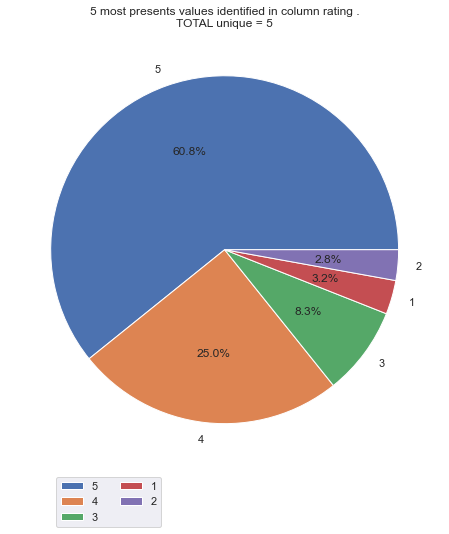

,rating
5,2909
4,1195
3,395
1,151
2,136


In [9]:
plot_ntops_pie(df_api, 'rating', 5, False, False)

### Stockage des données en fichier CSV


In [32]:
df_api.to_csv(filename_csv, encoding='utf-8', index=False)
print(f'JSON files {filename_paris_json} & {filename_london_json} have been converted in CSV {filename_csv}')

JSON files ./API_Extract/data4.json & ./API_Extract/data5.json have been converted in CSV ./API_Extract/data_paris_london.csv


## Chargement des modèles

Comme nous l'avons fait lors de l'analyse des données et des modèles, nous utilisons la **libraire Joblib** pour ré-utiliser nos modèls à partir de nouvelles données acquises depuis l'API.

In [5]:
#Chargement des modèle
#A voir ici si besoin : https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.load

#Chargement du modèle d'encodage tfidf entrainé précédemment? #tfidf = TfidfVectorizer(min_df=0.005,max_df=0.8)
tfidf = load('./Models/tfidfvectorizer.joblib')

tfidf_gensim = load('./Models/tfidf_gensim.joblib')

# Chargement  du modèle LDA   #lda_tfidf.fit(values_tfidf)
lda_tfidf_api = load('./Models/lda_tfidf.joblib')

# Chargement  du modèle NMF   #nmf.fit(values_tfidf)
#nmf_api = load('./Models/nmf.joblib')

# Chargement  du modèle lda_gensim   #lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
#A regarder : https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.save
lda_gensim_api = load('./Models/lda_gensim.joblib')


### Creation d'un pipeline

Quelques sources d'informations disponibles ci-dessous:

[Pipeline Intro](https://towardsdatascience.com/my-first-nlp-pipeline-99d24aafb773) -
[Pipeline and Custom transformer](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156) - 
[Pipeline with NLTK](https://nlpforhackers.io/building-a-nlp-pipeline-in-nltk/) - 
[Pipeline SKlearn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) - 
[Sample Pipelne Sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py) - 



In [6]:
def custom_nlp_pipeline(data: pd.DataFrame, max_score_filter=2, rating_column='rating', text_column='text', tag_type_to_eliminate=['NN','RB','RBR','IN','VB','VBN','VBG','VBZ','MD','CD','PRP','PRP$']):
    #filter on unstasfied comments (rating under max_score_filter variable)
    data = data.loc[(data[rating_column] <= max_score_filter), :].copy()
    
    # Change Text column to lower case
    data[text_column] = data.loc[:,text_column].str.lower()
    
    # Replace punct by blank
    data[text_column] = data.loc[:,text_column].str.replace(r'[^\w\s]+', '', regex=True)
    #data[text_column] = data[text_column].str.replace(r'[^\w\s]+', '', regex=True)
    
    # Remove numbers digits from text column
    data['text_only'] = data.loc[:,text_column].str.replace(r'[\d]+', '', regex=True) 
    #data['text_only'] = data[text_column].str.replace('\d+', '', regex=True)
    
    # Words splitting
    data = tokenize_text(data, 'text_only')
    #Remove all unecessary tagged words (Adverbs, Verbs, ...)
    data = remove_undesired_wordtag(data, 'tokenized_text', tag_type_to_eliminate)
    
    # Words cleaning
    data = stopwords_text(data, 'removed_tag_text')
    data = lemmatize_text(data, 'stopwords_text')
    
    #Création du bag of words
    data['thesaurus'] = data.loc[:,'lemmatized_text'].apply(lambda x: " ".join(x))
    
    #Extraction des features avec Tf-Idf Vectorizer : min_df=0.01,max_df=0.8 (précedemment entrainé, et chargé depuis Joblib précedemment)
    values = tfidf.transform(data['thesaurus'])
    #values = tfidf.fit_transform(data['thesaurus'])
    print("Created %d X %d TF-IDF-normalized document-term matrix" % (values.shape[0], values.shape[1]) )
    
    #From the thesaurus text, split each word and create new dataframe counting word presence frequency
    word_frequency = data.thesaurus.str.split(expand=True).stack().value_counts()
    word_frequency = pd.DataFrame({'word':word_frequency.index, 'word_count':word_frequency.values})
    #For each word, determne its TAG type
    word_frequency['word_tag'] = word_frequency['word'].apply(lambda x: nltk.pos_tag([x])[0][1])
    
    return(data, tfidf, values, word_frequency)


# Init the Stopword language
stop = stopwords.words('english')

#Function to remove useless words 
def stopwords_text(df, column):
    #df['stopwords_text'] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['stopwords_text'] = df.loc[:,column].apply(lambda x: [w for w in x if not w in stop and w.isalpha()])
    return (df)

# Init the Wordnet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

#Function to lemmatize text (Generic representation of words)
def lemmatize_text(df, column):
    #df['lemmatized_text'] = df.apply(lambda row: lemmatizer.lemmatize(row[column]), axis=1)
    df['lemmatized_text'] = df[column].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    #df['lemmatized_text'] = df.loc[:,column].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    return (df)

# Init the Tokenizer
tokenizer = nltk.RegexpTokenizer(r'\w+')

#Function to tokenize text (split in array)
def tokenize_text(df, column):
    df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row[column]), axis=1)
    #df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row[column]))
    return (df)


def remove_undesired_wordtag(df, column, tag_type_to_eliminate):
    #df['removed_tag_text'] = df.apply(lambda row: pos_tag(row[column]), axis=1)
    df['removed_tag_text'] = df.apply(lambda row: ([s[0] for s in pos_tag(row[column]) if s[1] not in tag_type_to_eliminate]), axis=1)
    return df


### Traitement des données texte via le pipeline

In [10]:
#Define variables
max_score_filter=2
rating_column='rating'
text_column='text'
#tag_type_to_eliminate = ['NN','RB','RBR','IN','VB','VBN','VBG','VBZ','MD','CD','PRP','PRP$']
tag_type_to_eliminate = ['RB','RBR','MD','CD']

#Rune the pipeline on df_api data
df_api_pipeline, tfidf, values, word_frequency = custom_nlp_pipeline(df_api, max_score_filter, rating_column, text_column, tag_type_to_eliminate)
#df_api_pipeline.head(3)

word_frequency.head(10)

#print('pd.DataFrame(values.toarray())') #values_tfidf = pd.DataFrame(values.toarray())


Created 287 X 1546 TF-IDF-normalized document-term matrix


,word,word_count,word_tag
0,food,67,NN
1,place,65,NN
2,restaurant,53,NN
3,good,50,JJ
4,service,41,NN
5,review,39,NN
6,came,33,VBD
7,like,30,IN
8,time,26,NN
9,paris,24,NN


## Classification des données (par la réutilisation des modèles suavegardés)
### LDA: Résultats de classification

Nous allons désormais consolider les résultats provenant de la matrice **values** afin de les classifier

[Voir doc LDA Sickit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

In [118]:
#pd.DataFrame(lda_tfidf_api.transform(values_tfidf))
#pd.DataFrame(lda_tfidf_api.transform(values_tfidf)).idxmax(axis=1)

In [11]:
def simple_topic_name(row):
    if row['Topic'] == 0:
        val = 'Nourriture, Aliments et Gouts'
    elif row['Topic'] == 1:
        val = 'Réservation'
    elif row['Topic'] == 2:
        val = 'Bar et boissons'
    else:
        val = 'Temps d attente et Service'
    return val


In [12]:
values_tfidf = pd.DataFrame(values.toarray())

#Nous selectionnons ici le modèle LDA, que nous avions persister dans un fichier JobLib
topic_result = pd.DataFrame(lda_tfidf_api.transform(values_tfidf)).idxmax(axis=1)
#topic_result = pd.DataFrame(lda_gensim_api.transform(values_tfidf)).idxmax(axis=1)

#values_tfidf.head()

df_api_results = pd.concat([df_api_pipeline.loc[:, ['rating', 'text', 'name']].reset_index(drop=True), pd.DataFrame(lda_tfidf_api.transform(values_tfidf)).reset_index(drop=True)], axis = 1)
df_api_results['Topic'] = topic_result
df_api_results['Topic_name'] = df_api_results.apply(simple_topic_name, axis=1)
df_api_results

,rating,text,name,0,1,2,3,Topic,Topic_name
0,2,i went back and forth trying to figure out wha...,Le Comptoir de la Gastronomie,0.063620,0.808858,0.063878,0.063644,1,Réservation
1,1,warning tourist trap restaurant this restaura...,Le Comptoir de la Gastronomie,0.079374,0.762068,0.079165,0.079393,1,Réservation
2,2,disappointed this time around as hubby wanted ...,Berthillon,0.063654,0.310786,0.065063,0.560497,3,Temps d attente et Service
3,1,this place is permanently closed please update...,La Coïncidence,0.068485,0.070398,0.069626,0.791491,3,Temps d attente et Service
4,2,decent restaurant but very packed and very sma...,Eggs & Co,0.067211,0.803567,0.066689,0.062533,1,Réservation
...,...,...,...,...,...,...,...,...,...
282,1,while its in a lovely vacation in the park by ...,The Pavilion Cafe,0.065000,0.805708,0.063501,0.065792,1,Réservation
283,2,service and desert were excellent appetizer o...,Locanda Locatelli,0.783298,0.071832,0.074606,0.070264,0,"Nourriture, Aliments et Gouts"
284,2,thismight be the best burrito in london wow th...,Daddy Donkey Mexican Grill,0.824170,0.060227,0.057989,0.057614,0,"Nourriture, Aliments et Gouts"
285,2,i would describe my experience here as very un...,Sen Viet,0.772822,0.078068,0.073942,0.075168,0,"Nourriture, Aliments et Gouts"


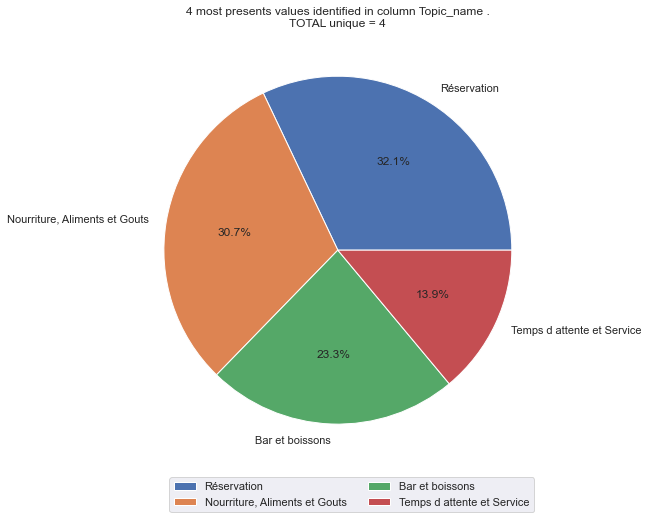

,Topic_name
Réservation,92
"Nourriture, Aliments et Gouts",88
Bar et boissons,67
Temps d attente et Service,40


In [14]:
n_topics = 4
plot_ntops_pie(df_api_results, 'Topic_name', n_topics, False, False)
#pairplot_columns(df_api_results, ['name', 'Topic'], False, 'rating')

### Visualisation des Topics obtenus avec le nouveau jeu de donnée API, en utilisant le modèle LDA pré-entrainé

In [120]:
# Créer le modèle LDA
#lda_tfidf = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# Fitter sur les données
#lda_tfidf.fit(values_tfidf)

pyLDAvis.sklearn.prepare(lda_tfidf_api, values, tfidf)

C:\Users\blanc\anaconda3\envs\IA_Project6\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\blanc\anaconda3\envs\IA_Project6\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.017362  0.040000       1        1  29.169149
0      0.124986  0.017669       2        1  28.862482
2      0.007527 -0.066470       3        1  24.920758
3     -0.115151  0.008802       4        1  17.047611, topic_info=         Term      Freq     Total Category  logprob  loglift
1322    table  2.000000  2.000000  Default  30.0000  30.0000
232   chicken  2.000000  2.000000  Default  29.0000  29.0000
823    minute  3.000000  3.000000  Default  28.0000  28.0000
203       car  1.000000  1.000000  Default  27.0000  27.0000
1112     room  1.000000  1.000000  Default  26.0000  26.0000
...       ...       ...       ...      ...      ...      ...
380      dont  0.586395  3.260504   Topic4  -5.4992   0.0535
430      even  0.547276  3.093126   Topic4  -5.5682   0.0372
559        go  0.547958  3.667316   Topic4  -5.5670  -0.1319
1495     went  0.506121  2.432927   Topic4  -5.6464   0.1991
976     place  0.495602  5.537522   Topic4  -5.6674  -0.6444

[293 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
37        1  0.749654   always
66        1  0.797859     area
71        3  1.072350  arrived
75        3  0.445203    asked
98        1  0.264388     back
...     ...       ...      ...
1525      1  0.271593    would
1525      2  0.271593    would
1525      3  0.271593    would
1525      4  0.271593    would
1544      1  1.062700    youre

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

La classification LDA nous permet donc d'associer chacun des commentaire dans un topic existant, tout en respectant le modèle entrainé.
Interpretation des 4 Topics LDA:

    - Topic 1 : Temps d'attente et Service
    - Topic 2 : Nourriture, Aliments et Gouts
    - Topic 3 : Attente et Service
    - Topic 4 : Reservation


Cependant, l'étude du score de cohérence ayant été fait sur le modèle GENSIM, nous allons également vérifier la classification en utilisant le nouveau jeu de données avec GENSIM.

### GENSIM : Résultats de Classification 

In [121]:
n_topics = 4 #coherence_values.index(max(coherence_values))+start

# Créer le dictionnaire
dataset = [d.split() for d in df_api_pipeline['thesaurus']]
id2word = corpora.Dictionary(dataset)
# Créer le corpus
texts = dataset
corpus = [id2word.doc2bow(text) for text in texts]

# step 1 -- Reuse TFIDF model
corpus_tfidf = tfidf_gensim[corpus]

# Construire le modèle LDA, avec n_topics = 4 (comme le LDA précedent, mais en utilisant GENSIM)
#lda_gensim_api = load('./Models/lda_gensim.joblib')
# later on, load trained model from file
lda_gensim_api =  LdaModel.load('./Models/lda_gensim.model')

#model =  models.LdaModel.load('lda.model')
lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=n_topics, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_gensim, corpus_tfidf, id2word)
vis

C:\Users\blanc\anaconda3\envs\IA_Project6\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.086834 -0.005543       1        1  76.853531
1     -0.053998 -0.015847       2        1  16.060014
0     -0.018564  0.016092       3        1   4.234905
2     -0.014273  0.005298       4        1   2.851550, topic_info=        Term      Freq     Total Category  logprob  loglift
300        u  1.000000  1.000000  Default  30.0000  30.0000
528     look  1.000000  1.000000  Default  29.0000  29.0000
180     made  1.000000  1.000000  Default  28.0000  28.0000
12        go  1.000000  1.000000  Default  27.0000  27.0000
423   seated  1.000000  1.000000  Default  26.0000  26.0000
...      ...       ...       ...      ...      ...      ...
1163  ticket  0.058022  0.497986   Topic4  -6.1105   1.4076
793    verde  0.044425  0.379883   Topic4  -6.3775   1.4112
804    fried  0.050298  0.658231   Topic4  -6.2534   0.9857
798    salad  0.052328  0.799107   Topic4  -6.2138   0.8313
55    cheese  0.047549  0.573015   Topic4  -6.3096   1.0682

[170 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
218       1  0.902550       asked
209       1  0.849244         bad
750       2  0.907870         bar
456       1  0.904043        best
701       1  0.957934  california
64        1  1.035248        came
359       1  0.937605        cold
241       1  0.794180        come
252       1  0.867722     decided
171       1  0.829908      dinner
197       1  1.018110        dont
626       2  1.202106   expensive
396       1  0.932542  experience
2         1  0.851994        food
804       1  1.519223       fried
391       1  1.040889      friend
12        2  0.843433          go
67        1  1.001795        good
293       1  0.889342         got
68        1  1.092908       great
337       2  0.856290       hotel
92        1  0.990963          im
511       1  0.939524        left
190       1  0.924140        like
528       2  0.600595        look
180       2  0.788846        made
308       1  0.810806       paris
40        1  0.998911       place
377       1  1.087489       price
14        1  0.910150  restaurant
99        1  1.023094      review
798       1  1.251396       salad
423       2  0.847909      seated
6         1  0.942608     service
345       1  0.870890     someone
972       2  1.092379     special
7         1  1.046722        star
331       1  1.135350       table
908       2  1.023950         tea
206       2  0.936779        told
177       1  0.838949        took
455       1  0.960464         try
300       2  1.001589           u
505       2  1.202114       vegan
230       1  0.952420      waiter
34        1  0.815271      wanted
9         1  0.931657        went
18        1  0.927189       worst, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

### Visualisation des Topics

In [111]:
#lda_gensim[corpus_tfidf[0]][0]

In [112]:
#corpus_tfidf[0]


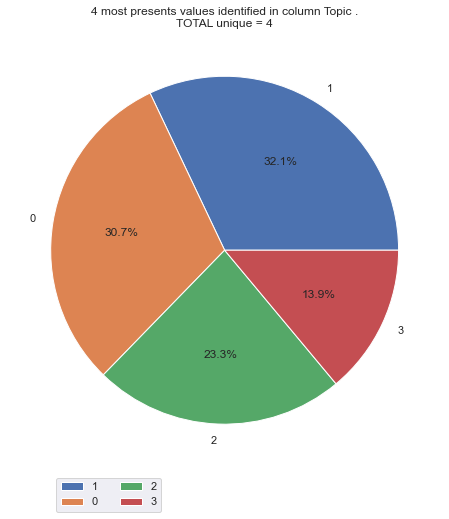

,Topic
1,92
0,88
2,67
3,40


In [125]:
n_topics = 4

plot_ntops_pie(df_api_results, 'Topic', n_topics, False, False)
#pairplot_columns(df_api_results, ['name', 'Topic'], False, 'rating')

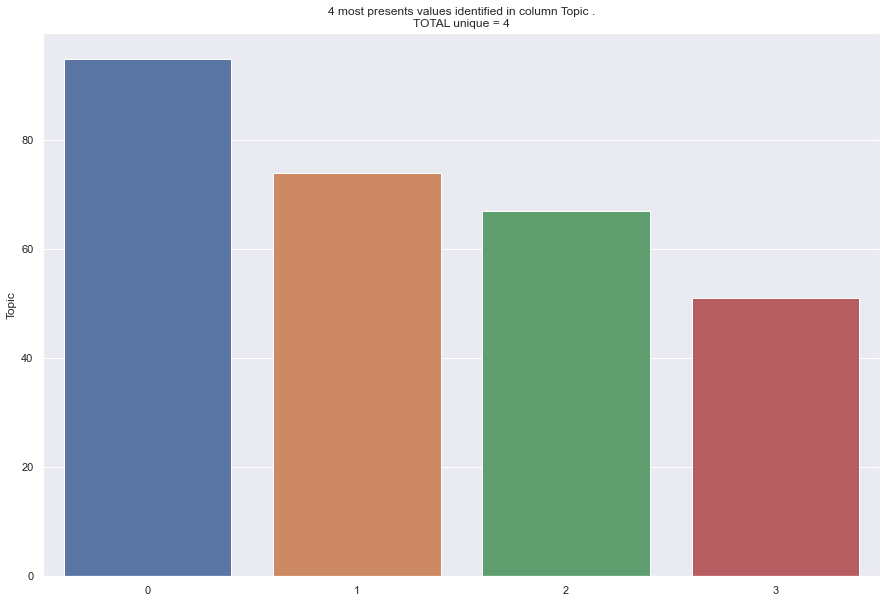

,Topic
0,95
1,74
2,67
3,51


In [114]:
plot_ntops_bar(df_api_results, 'Topic', n_topics, False, False)

Nous reprenons donc la conclusion tirée du jeu de donnée initiale, et allons confirmer si l'interprétation des 4 Topics semble cohérente avec le nouveau jeu de donnée:


# Création de l'Application Web

L'idée est de produire une page web avec des représentations graphiques des données textes (via Streamlit) :


In [64]:
import streamlit as st

In [65]:
st.dataframe(df_api_results)


C:\Users\blanc\anaconda3\envs\IA_Project6bis\lib\site-packages\streamlit\type_util.py:379: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = pa.Table.from_pandas(df)


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [21]:
#st.dataframe(df_api_results.style.highlight_max(axis=1))